#### 1. Import Libraries

In [1]:
# Importing the Keras libraries and packages

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing import image


In [2]:
# ---------- Data Loading and Preprocessing ----------

# Defining image dimensions and other parameters
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

dataset_dir = './dataset/training_set/'


#### 2. Load and create datasets with an 80/20 split


In [3]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

# Creating the training dataset (80% of the data)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,  # 20% of the data will be used for validation
    subset="training",
    seed=2048,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

# Creating the validation dataset (20% of the data)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=2048,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)


Found 8005 files belonging to 2 classes.
Using 6404 files for training.
Found 8005 files belonging to 2 classes.
Using 1601 files for validation.


In [4]:
# Getting class names

class_names = train_dataset.class_names
print("Class Names:", class_names)


Class Names: ['cats', 'dogs']


In [5]:
# --- Data Augmentation ---

# Creating a model with Keras preprocessing layers.
data_augmentation = Sequential(
    [
        RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        RandomRotation(0.1),  # a fraction of 2*pi
        RandomZoom(0.1),     # a fraction of the original size
    ]
)

# --- Apply Preprocessing ---
# Applying the data augmentation ONLY to the training dataset.
# No augmentation for validation or test data.
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y))


/Users/aniruddhamukherjee/miniforge3/envs/kiit-dl/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
# Next, normalizing pixel values to be between 0 and 1 for all datasets.

normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(
    lambda x, y: (normalization_layer(x), y))


#### 3. Build the CNN model as specified

In [7]:
# -------- Model Building --------

# Conv2D → ReLU → MaxPooling → Conv2D → ReLU → MaxPooling → Flatten → Dense → ReLU → Dense → Sigmoid.


model = Sequential([
    # Input layer with the correct shape
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Block
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flattening and Dense Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification (cat or dog)
])


#### 4. Compile the model


In [8]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [9]:
# Display the model's architecture
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,801 (14.10 MB)

 Trainable params: 3,696,801 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

#### 5. Train the model for 10-15 epochs


In [10]:
# ------ Model Training ------

epochs = 25
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)


Epoch 1/25
201/201 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - accuracy: 0.5012 - loss: 0.7130 - val_accuracy: 0.5128 - val_loss: 0.6924
Epoch 2/25
201/201 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - accuracy: 0.5450 - loss: 0.6881 - val_accuracy: 0.5678 - val_loss: 0.6850
Epoch 3/25
201/201 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.5826 - loss: 0.6737 - val_accuracy: 0.5984 - val_loss: 0.6854
Epoch 4/25
201/201 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.6230 - loss: 0.6547 - val_accuracy: 0.5590 - val_loss: 0.7253
Epoch 5/25
201/201 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.6516 - loss: 0.6320 - val_accuracy: 0.6802 - val_loss: 0.6071
Epoch 6/25
201/201 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.6839 - loss: 0.6021 - val_accuracy: 0.6690 - val_loss: 0.6031
Epoch 7/25
201/201 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.6958 - loss: 0.5769 - val_accuracy: 0.7133 - val_loss: 0.5715
Epoch 8/25
201/201 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.7025 - loss: 0.5724 - 

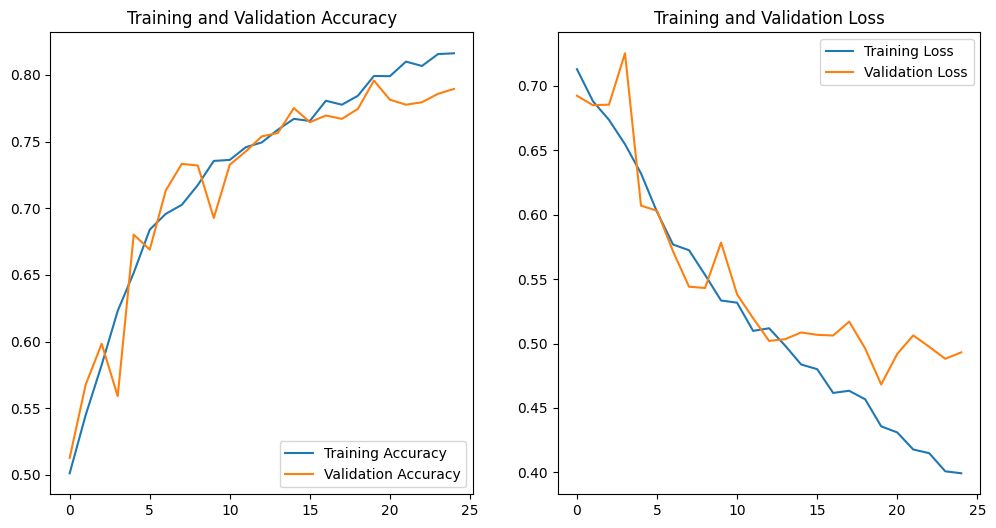

In [11]:
# ------------ Plotting Training & Validation Curves ------------

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#### 6. Evaluate the model with the test set


In [12]:
# ------- Model Evaluation and Prediction -------

# First, preparing the test dataset
test_dataset_dir = './dataset/test_set/'

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dataset_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False  # No need to shuffle for evaluation
)
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

print("\n--- Evaluating on Test Data ---")
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


Found 2023 files belonging to 2 classes.

--- Evaluating on Test Data ---
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7756 - loss: 0.5144
Test Accuracy: 77.56%


In [13]:
# Test with a few random images from the test set

def predict_random_image(model, test_dir):
    # Getting subdirectories (cats, dogs)
    subdirs = [d for d in os.listdir(
        test_dir) if os.path.isdir(os.path.join(test_dir, d))]

    # Picking a random class and a random image
    random_class = np.random.choice(subdirs)
    random_image_file = np.random.choice(
        os.listdir(os.path.join(test_dir, random_class)))
    img_path = os.path.join(test_dir, random_class, random_image_file)

    # Loading and preprocessing the image
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    img_array = normalization_layer(img_array)

    # Making a prediction
    predictions = model.predict(img_array)
    score = predictions[0][0]

    # Display the image and prediction
    plt.imshow(img)
    plt.axis('off')
    prediction_label = "Dog" if score > 0.5 else "Cat"
    plt.title(
        f"Prediction: {prediction_label} ({score:.2f}) \nActual: {random_class.capitalize()}")
    plt.show()



--- Testing with a few random images ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


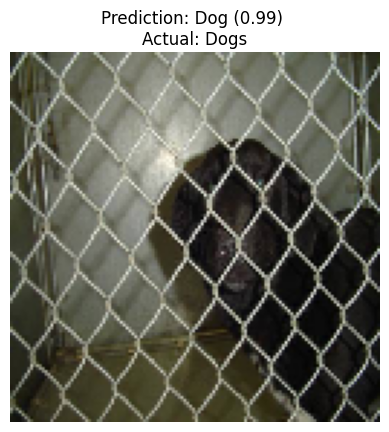

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


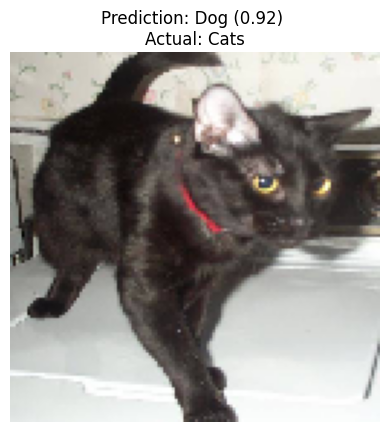

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


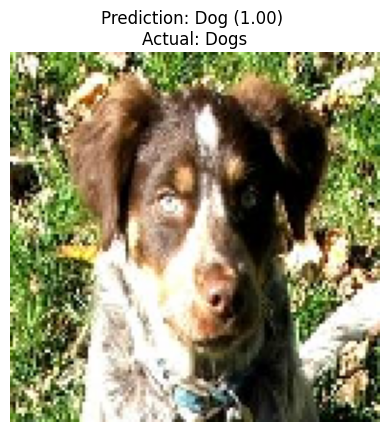

In [14]:

# Running a few predictions
print("\n--- Testing with a few random images ---")
for _ in range(3):
    predict_random_image(model, test_dataset_dir)


In [15]:
# Save the final model
model.save("cats_vs_dogs_classifier.h5")
print("\nModel saved as cats_vs_dogs_classifier.h5")



Model saved as cats_vs_dogs_classifier.h5
